# Evolutionary game theory

### Appearance of cooperative behaviors in complex networks based on evolutionary games.

Based on the work presented in "Evolutionary game theory: Temporal and spatial effects beyond
replicator dynamics" (Roca, Cuesta, Sánchez)

In [2]:
import networkx as nx
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline

We will concentrate on these “lines” of the T-S space:

- the weak prisoner’s dilemma: T in [1,2], S=0

- stag hunt: the diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)

- snow drift: the diagonal line between (T,S)=(1,1) and (T,S)=(2,0)

Analyzing the whole space is very time consuming, although it can be done.

The dynamic works as follows. Nodes can be cooperators (C) or defectors (D). At each time step:

- as initial condition, each node is assigned as C or D randomly, with equal probability (0.5 each).

- all nodes calculate their payoff, which is equal to the sum of the payoffs obtained by playing with each of their neighbors. When a C plays with a C, it obtains 1.0; C playing with D obtains S; D playing with C obtains T; and D playing with D obtains 0.0.

- after the total payoffs of all nodes is computed, then nodes may change their strategy C or D by comparing their payoffs with that from one randomly chosen neighbor. There are different methods: replicator rule, Fermi rule, unconditional imitation, Moran rule, etc.

- if all nodes become C (or D) then the dynamic stops. Otherwise, ensure the Monte Carlo simulation is long enough to be in the stationary state. This is specially important for the Snow-Drift.

## Game simulation

In [13]:
Nrep = 20
d_0 = 0.5 #initial fraction of defector nodes 
Tmax = 500
Ttrans = 400

# C: collaborators
# D: defectors

def payoff_node(n, G, C, S, T): #calculates the total payoff of node n playing against its neighbors
    payoff = 0
    if n in C:
        for i in G.neighbors(n):
            if i in C:
                payoff += 1
            else:
                payoff += S
    else:
        for i in G.neighbors(n):
            if i in C:
                payoff += T
            else:
                payoff += 0
    return payoff                        

def game_simulation(G,T,S, update_rule, plot_time=False): #computes one rep of the Monte Carlo simulation
    #S: Suckers payoff
    #T: temptation payoff
    nodes = list(G.nodes())
    C = set(nodes) #cooperators
    N = len(nodes)
    n_d_0 = round(d_0 * N) #number of defectors at time 0
    D_0 = set(rd.sample(C, n_d_0)) #defectors at time 0
    C = C - D_0 #cooperators at time 0
    P = 0 
    p_t=[len(C)/N,]
    for t in range(0,Tmax):
        #print(f'time: {t}')
        payoffs = []
        for n in nodes:
            payoffs.append(payoff_node(n,G, C, S, T))
        new_C = set() # nomore_D
        new_D = set() # nomore_C
        #we store the new C and D nodes in temporary variables, we will updated the C and D sets at the end of the loop
        for i in nodes: 
            s = update_rule(i,G, C, S, T, payoffs)
            if s == 'C':
                new_C.add(i)
            if s == 'D':
                new_D.add(i)
        C = (C | new_C) - new_D #synchronous update: every player is updated at the same time
        #D = (D | new_D) - new_C

        C_len = len(C)
        if C_len == 0:
            #print(f'time: {t}')
            return 0
        if C_len == N:
            #print(f'time: {t}')
            return 1
            
        if plot_time == True:
            #print(f'X* = {C_len/N}')
            p_t.append(C_len/N)

        if t>=Ttrans:
            P += len(C)
            
    p = P/(N*(Tmax-Ttrans))
    
    if plot_time == True:
        plt.figure(figsize=(10,6))
        plt.title(f'N = {N}, S = {S}, T = {T}')
        plt.plot(p_t)
        plt.xlabel('time')
        plt.ylabel('fraction of cooperators')
        
    return p


## Update rules

In [14]:
def replicator_rule(i,G, C, S, T, payoffs):
    Ni = list(G.neighbors(i))
    ki = len(Ni)
    if Ni!=[]:
        j = rd.choice(Ni)                
        if payoffs[j] > payoffs[i]:
            #Nj = list(G.neighbors(j))
            kj = G.degree(j) #len(Nj)
            phi = max(ki,kj)*(max(1,T) - min(0,S)) #normalizing factor
            probability = (payoffs[j]-payoffs[i])/phi
            if rd.random() < probability:
                if j in C:
                    return 'C'
                else:  
                    return 'D'

In [15]:
def multiple_replicator_rule(i,G, C, S, T, payoffs):
    Ni = list(G.neighbors(i))
    ki = len(Ni)
    probabilities = {}
    if Ni==[]:
        return
    for j in Ni:
        if payoffs[j] > payoffs[i]:
            #Nj = list(G.neighbors(j))
            kj = G.degree(j) #len(Nj)
            phi = max(ki,kj)*(max(1,T) - min(0,S)) #normalizing factor
            probabilities[j] = (payoffs[j]-payoffs[i])/phi
    if probabilities == {}:
        return
    #fixed_strategy_probability = np.prod([1-prob for prob in probabilities])
    #if rd.random() < fixed_strategy_probability:
    #    return
    for j in probabilities.keys():
        if rd.random() < probabilities[j]:
            if j in C:
                return 'C'
            else:  
                return 'D'

In [16]:
def unconditional_imitation_rule(i,G, C, S, T, payoffs): #“follow the best” rule
    j = np.argmax(payoffs)
    if payoffs[j] > payoffs[i]:
        if j in C:
            return 'C'
        else:  
            return 'D'

In [17]:
def moran_rule(i,G, C, S, T, payoffs): 
    #a player can adopt, with low probability, the strategy of a neighbor that has done worse than herself.
    Ni = list(G.neighbors(i))
    ki = len(Ni)
    if Ni==[]:
        return 
    j = rd.choice(Ni)
    psi = ki
    for n in Ni:
        kn = G.degree(n) #len(list(G.neighbors(n)))
        if kn > psi:
            psi = kn
    psi *= min(0,S)
    probability = (payoffs[j] - psi)/ np.sum([payoffs[k]-psi for k in Ni+[i]])
    if rd.random() < probability:
        if j in C:
            return 'C'
        else:  
            return 'D'

In [18]:
def fermi_rule(i,G, C, S, T, payoffs): 
    Ni = list(G.neighbors(i))
    if Ni!=[]:
        j = rd.choice(Ni)   
        beta = 0.1 #inverse of temperature, controls the intensity of selection
        probability = 1/(1+np.exp(-beta*(payoffs[j]-payoffs[i])))
        if rd.random() < probability:
            if j in C:
                return 'C'
            else:  
                return 'D'

## Monte Carlo simulation

In [28]:
n_points = 50

def MC(G, Nrep, T, S, update_rule):
    sum_p = 0
    for _ in range(0,Nrep):
        sum_p += game_simulation(G, T, S, update_rule)
    return sum_p/Nrep

def weak_prisoner_dilemma(): # weak prisoner’s dilemma: T in [1,2], S=0
    print('weak prisoner’s dilemma: T in [1,2], S=0')
    t_list = np.linspace(1.0, 2.0, num=n_points)
    s_list = np.zeros(len(t_list))
    return list(zip(t_list, s_list))

def stag_hunt(): #stag hunt: the diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)
    print('stag hunt: diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)')
    t_list = np.linspace(0, 1.0, num=n_points)
    s_list = np.linspace(0, -1, num=n_points)
    return list(zip(t_list, s_list))

def snow_drift(): #snow drift: the diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
    print('snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)')
    t_list = np.linspace(1, 2.0, num=n_points)
    s_list = np.linspace(1, 0, num=n_points)
    return list(zip(t_list, s_list))

def plots(G, name, game, update_rules = [replicator_rule, multiple_replicator_rule, unconditional_imitation_rule, moran_rule, fermi_rule]):
    _, ax = plt.subplots(figsize=(15,6))
    TS_list = game()
    TS_labels = [f'T,S = ({ts[0]:.3f},{ts[1]:.3f})' for ts in TS_list]
    plt.title(name + ' : ' + game.__name__)
    ax.set_ylim([0, 1])
    plt.grid()
    for update_rule in update_rules:
        print(update_rule.__name__)
        p_list = []
        for t,s in TS_list:
            #print(f'T = {t}, S = {s}')
            p = MC(G, Nrep, t, s, update_rule)
            #print(f'p = {p}')
            p_list.append(p)
        ax.plot(TS_labels, p_list, '-o', markersize=3, label = update_rule.__name__)
    ax.set_xticklabels(labels = TS_labels, rotation=90)
    plt.xlabel('T,S')
    plt.ylabel('fraction of cooperators')
    plt.legend()
    #plt.savefig('plot_'+name +'_'+ game.__name__ + '.png')

## Complete graph

In [10]:
complete_graph_100 = nx.complete_graph(100)

weak prisoner’s dilemma: T in [1,2], S=0
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule
fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


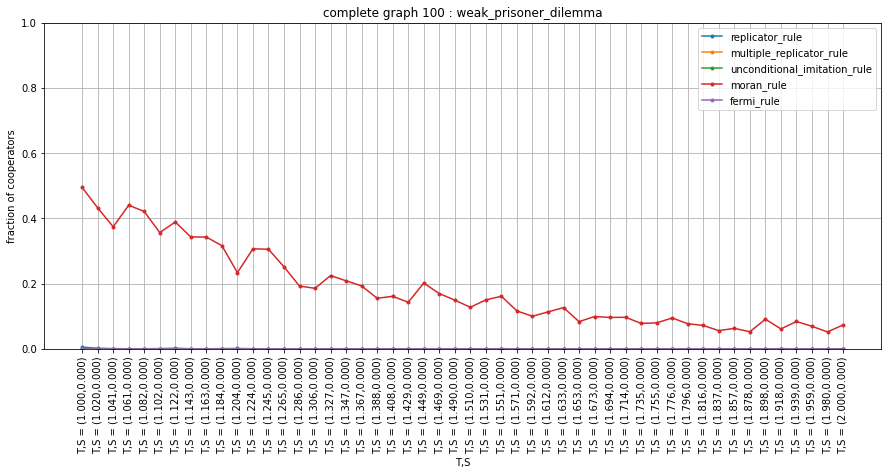

In [11]:
plots(complete_graph_100, 'complete graph 100', weak_prisoner_dilemma)

stag hunt: diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


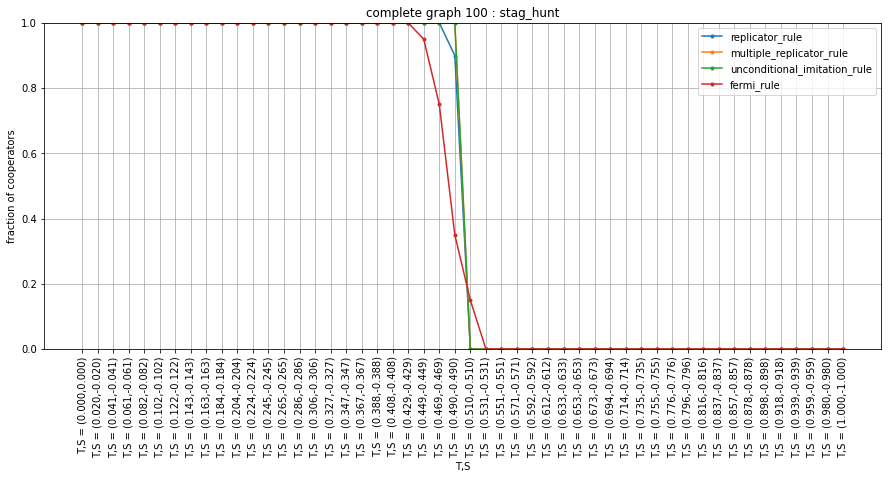

In [21]:
plots(complete_graph_100, 'complete graph 100', stag_hunt, update_rules=[replicator_rule, multiple_replicator_rule, unconditional_imitation_rule, fermi_rule])

snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


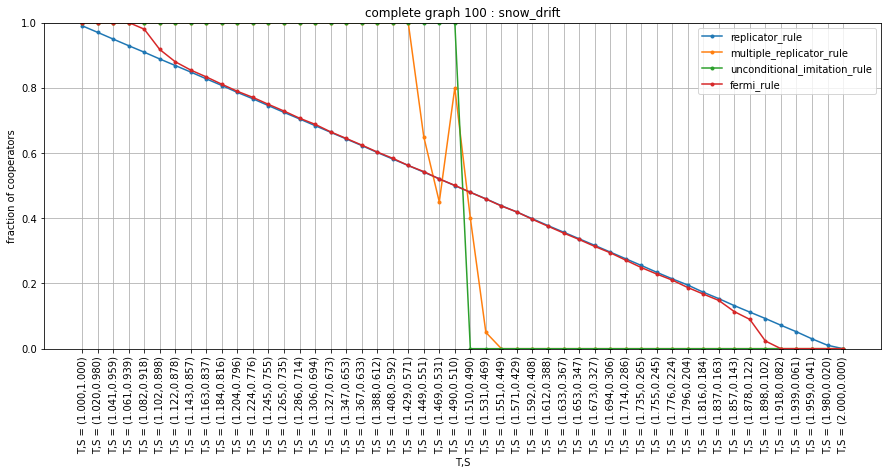

In [23]:
plots(complete_graph_100, 'complete graph 100', snow_drift, update_rules=[replicator_rule, multiple_replicator_rule, unconditional_imitation_rule, fermi_rule])

0.5

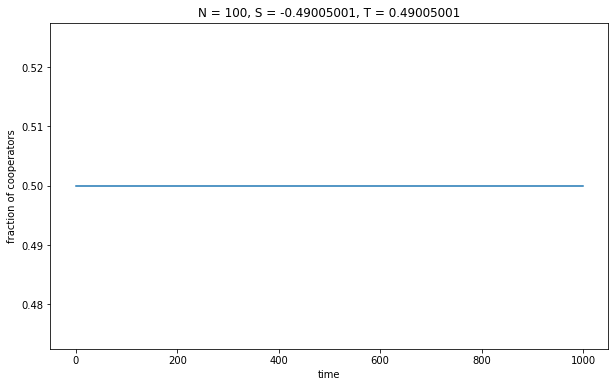

In [ ]:
# separator point for the stag hunt game, with replicator rule
game_simulation(complete_graph_100, T = 0.49005001, S = -0.49005001, update_rule=replicator_rule, plot_time=True)

As stated in the attached paper ["Evolutionary game theory: Temporal and spatial effects beyond
replicator dynamics" (Roca, Cuesta, Sánchez)], “for a complete network, i.e. for a well-mixed or unstructured population, the differences between update rules may be not relevant, as far as they do not change in general the evolutionary outcome. These differences, however, become crucial when the population has some structure”.
We will see that for other kinds of networks the choice of the update rule has greater consequences

## Homogeneous random graph

In [33]:
randregular_100_4 = nx.random_regular_graph(4,100)

weak prisoner’s dilemma: T in [1,2], S=0
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


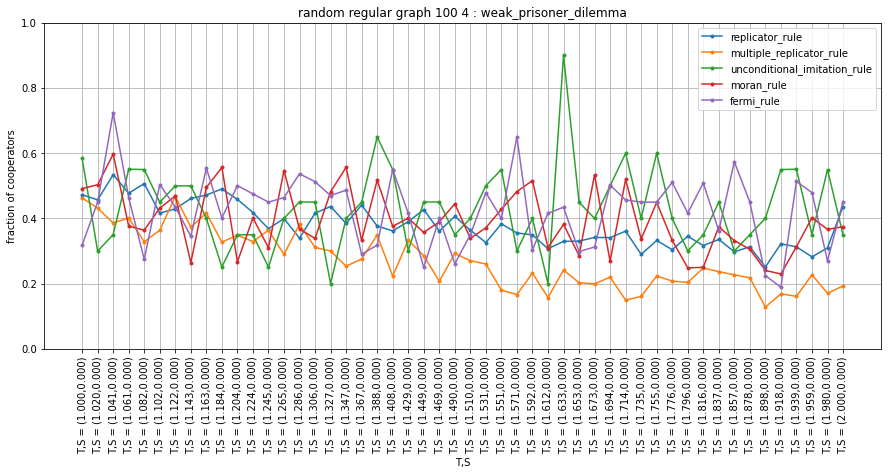

In [34]:
plots(randregular_100_4, 'random regular graph 100 4', weak_prisoner_dilemma)

stag hunt: diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


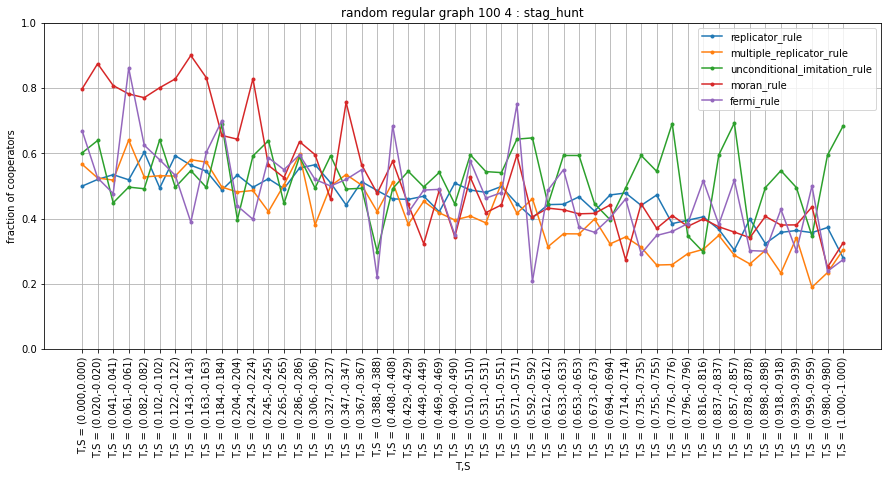

In [39]:
plots(randregular_100_4, 'random regular graph 100 4', stag_hunt)

snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
replicator_rule
unconditional_imitation_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


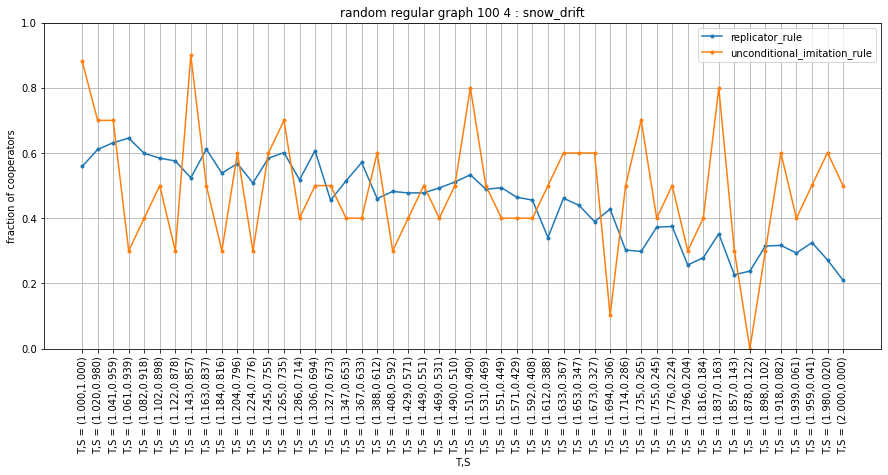

In [41]:
Nrep = 10
Tmax = 1000
Tmin = 900
plots(randregular_100_4, 'random regular graph 100 4', snow_drift, update_rules=[replicator_rule, unconditional_imitation_rule])

weak prisoner’s dilemma: T in [1,2], S=0
unconditional_imitation_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


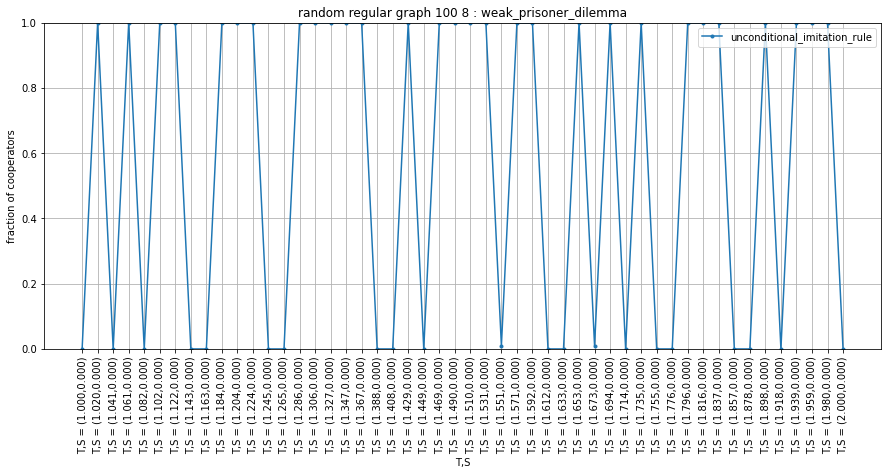

In [42]:
randregular_100_8 = nx.random_regular_graph(8,100)
Nrep = 1
plots(randregular_100_8, 'random regular graph 100 8', weak_prisoner_dilemma, update_rules=[unconditional_imitation_rule])

0.24122291666666668

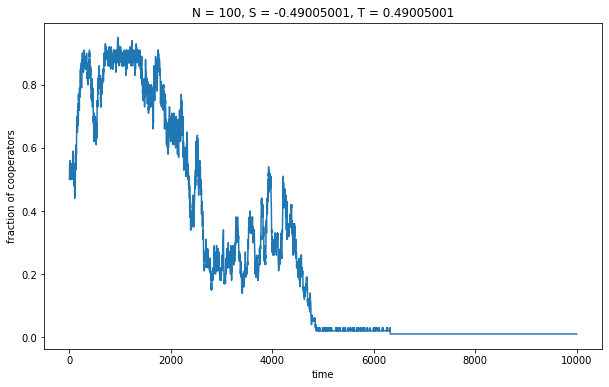

In [49]:
Tmax = 10000
game_simulation(randregular_100_8, T = 0.49005001, S = -0.49005001, update_rule=replicator_rule, plot_time=True)

snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


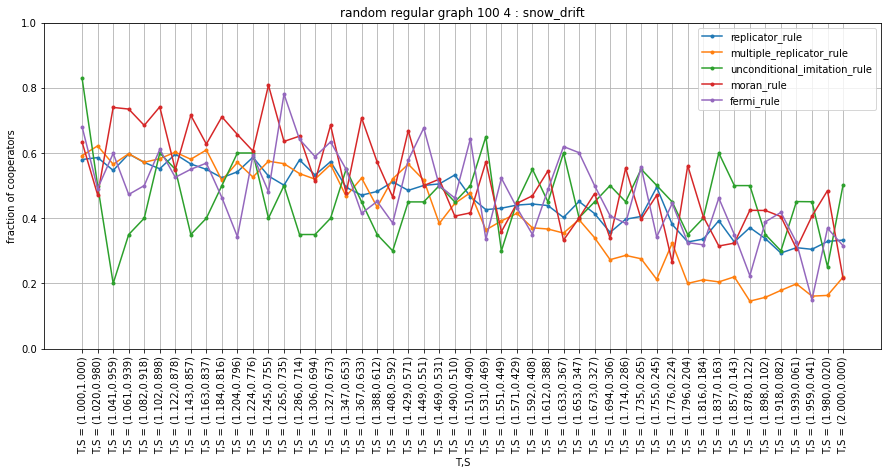

In [40]:
plots(randregular_100_4, 'random regular graph 100 4', snow_drift)

## Barabasi Albert graph

In [24]:
#Barabasi Albert graph
N = 100
K = 4
BA_100_4 = nx.barabasi_albert_graph(N, K)

weak prisoner’s dilemma: T in [1,2], S=0
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


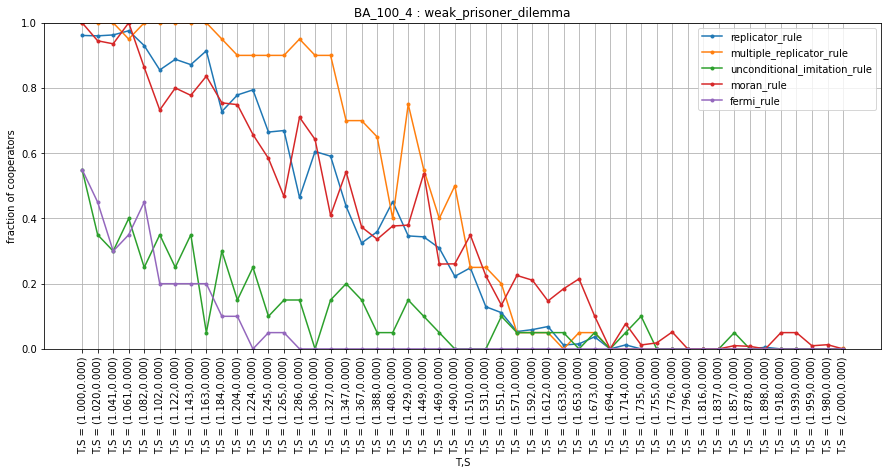

In [25]:
plots(BA_100_4, 'BA_100_4', weak_prisoner_dilemma)

stag hunt: diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


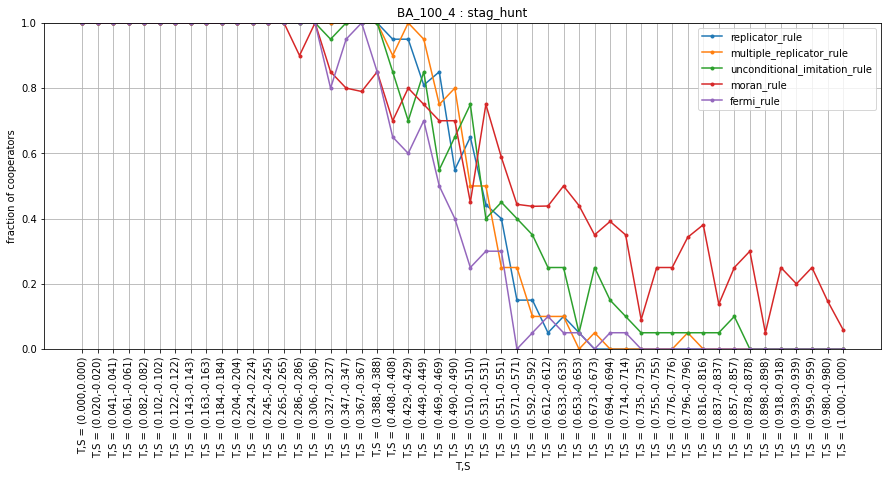

In [26]:
plots(BA_100_4, 'BA_100_4', stag_hunt)

snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


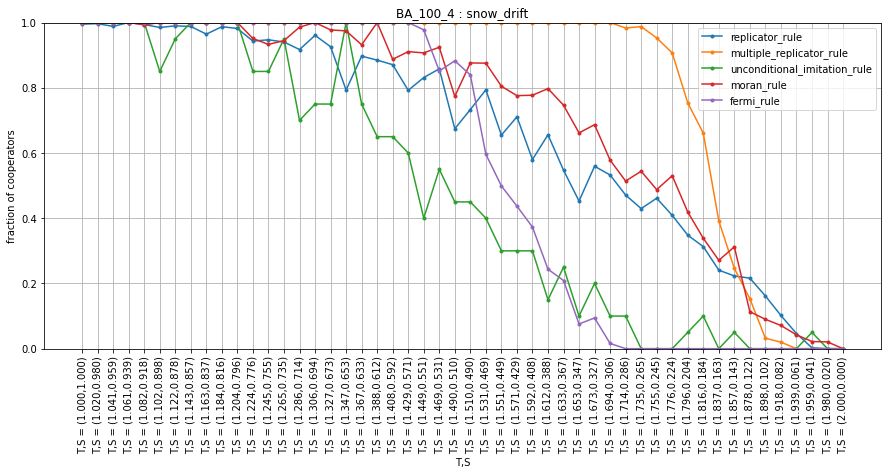

In [27]:
plots(BA_100_4, 'BA_100_4', snow_drift)

## Erdos Renyi graph

In [29]:
#ER graph

def ER_Gnk(N,K):
    G=nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    n_edges=0
    while n_edges<K:
        edge=rd.choice(list(combinations(G,2)))
        if (edge[0],edge[1]) not in G.edges():
            G.add_edge(edge[0],edge[1])
            n_edges+=1
    return G

N = 100
avg_degree = 4
K = N*(avg_degree)/2
ER_100_4 = ER_Gnk(N,K)


weak prisoner’s dilemma: T in [1,2], S=0
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


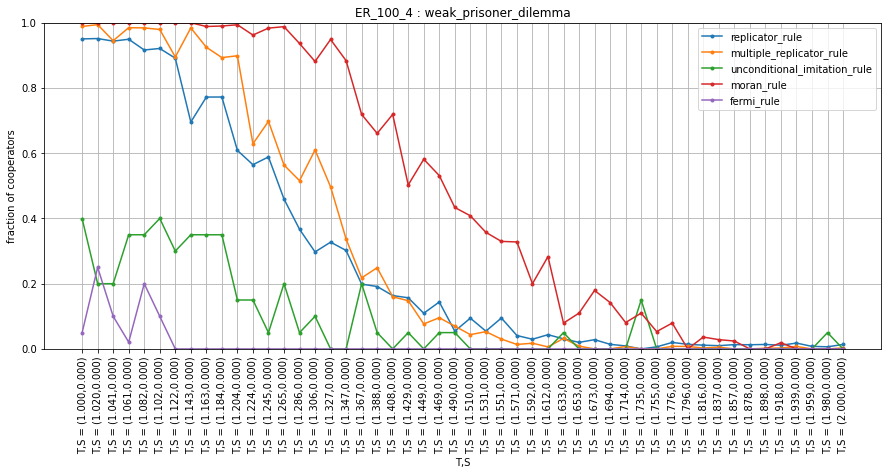

In [30]:
plots(ER_100_4, 'ER_100_4', weak_prisoner_dilemma)

stag hunt: diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


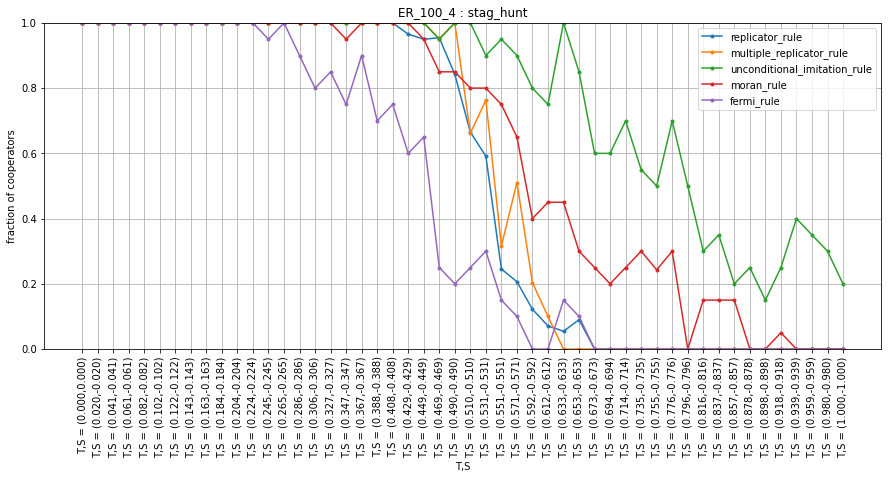

In [31]:
plots(ER_100_4, 'ER_100_4', stag_hunt)

snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


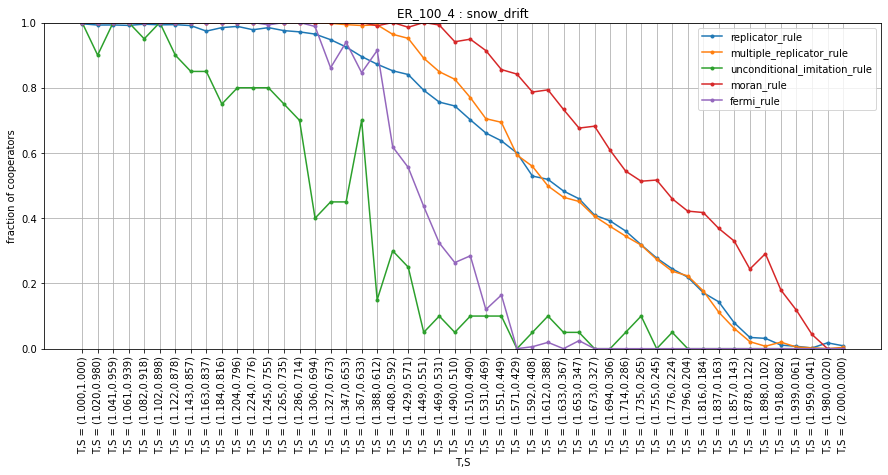

In [32]:
plots(ER_100_4, 'ER_100_4', snow_drift)

## Lancichinetti–Fortunato–Radicchi (LFR) community graph

In [ ]:
#LFR graph
n = 100
tau1 = 3
tau2 = 1.5
mu = 0.1
LFR_100 = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5, min_community=10)

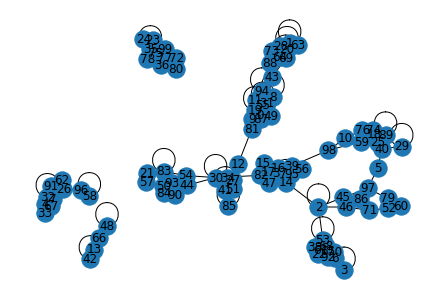

In [ ]:
nx.draw(LFR_100, with_labels=True)

weak prisoner’s dilemma: T in [1,2], S=0
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


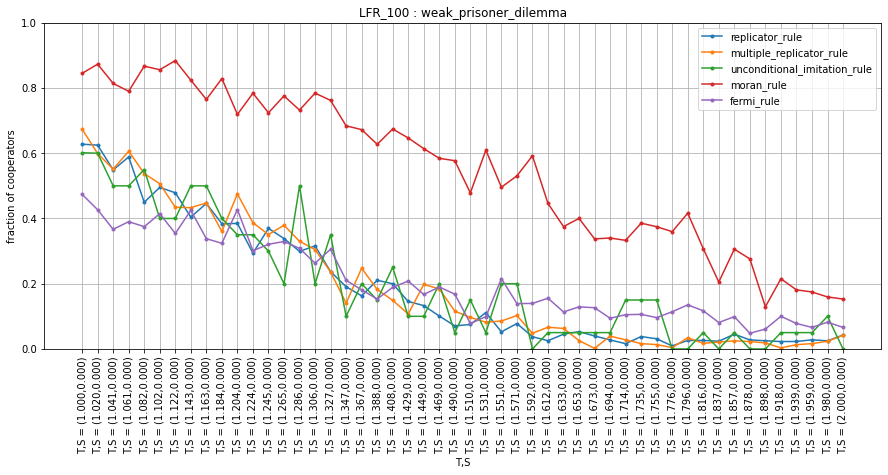

In [ ]:
plots(LFR_100, 'LFR_100', weak_prisoner_dilemma)

stag hunt: diagonal line between (T,S)=(0,0) and (T,S)=(1,-1)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


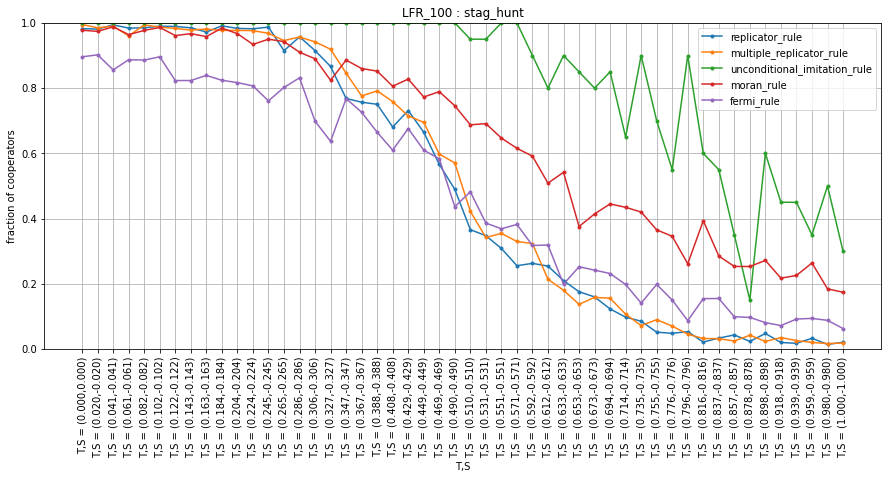

In [ ]:
plots(LFR_100, 'LFR_100', stag_hunt)

snow drift: diagonal line between (T,S)=(1,1) and (T,S)=(2,0)
replicator_rule
multiple_replicator_rule
unconditional_imitation_rule
moran_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


fermi_rule


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


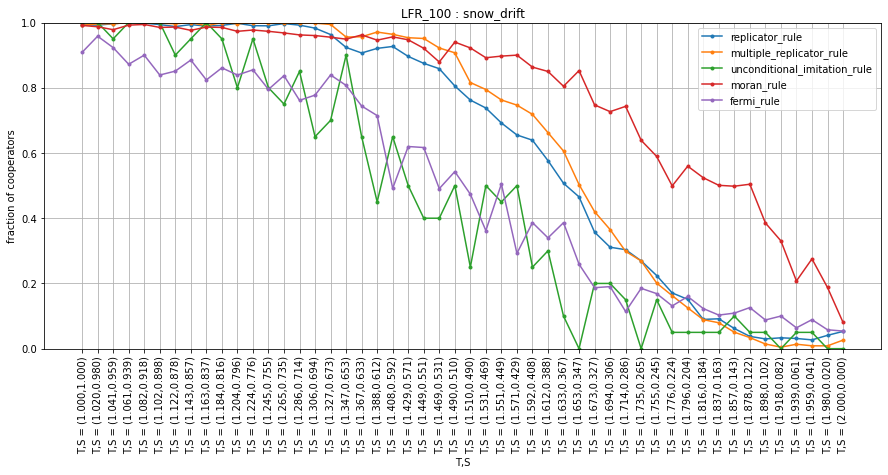

In [ ]:
plots(LFR_100, 'LFR_100', snow_drift)

In [ ]:
game_simulation(LFR_100, T = 1, S = 1, update_rule=moran_rule, plot_time=True)

NameError: name 'game_simulation' is not defined

"for a complete network, i.e. for a well-mixed or unstructured population, the differences between update rules may be not relevant, as far as they do not change in general the evolutionary out- come [121]. These differences, however, become crucial when the population has some structure"